# DIY Neural Network
For this first deep learning related blog post I will follow the tradition of deep learning bloggers doing a basic neural network for their first blog. The tradition is just though as it is a good exercise I believe everyone should do at least once. Even though it seems routine I hope though that I can present a different perspective than most others. In particular I will stray from any brain or neuron related analogies and explain the concepts more mathematically. 

I will do a few derivations but a large portion of the math will be left to the reader. Due to this I expect at least basic understanding of linear algebra, calculus, and some of the basics of machine learning.

## Import our Libraries
I will primarily use the Numpy library in this and future tutorials. If you are unfamiliar with Numpy I suggest you take a look at some of the following references:


I also use Matplotlib which has syntax very similar to that used in Matlab. scikit-learn is only used for importing our dataset but I encourage you to play around with other datasets to see how this code performs!

In [1]:
%matplotlib inline
import numpy as np
from sklearn.datasets import load_digits
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

import matplotlib
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Our Dataset
We will be working with scikit-learn's MNIST dataset in this tutorial. This dataset consists of a set of images of digits 0-9 in the form of a 8x8 array or 64 total pixels. This dataset is commonly used to benchmark neural network performance in the literature so it is good to get to know it now rather than later.

Before doing any kind of processing or running any machine learning algorithms you should always give at least a cursory glance at your data. In this case I am very familiar with this MNIST dataset and know the distribution of classes is relatively uniform, an image cannot have multiple labels, and other properties which are important in choosing your machine learning algorithm of choice. Because of this prior knowledge I only show what the images look like but I encourage you to get to know your data before simply throwing deep learning at it! In some cases you can get away with much simpler algorithms.

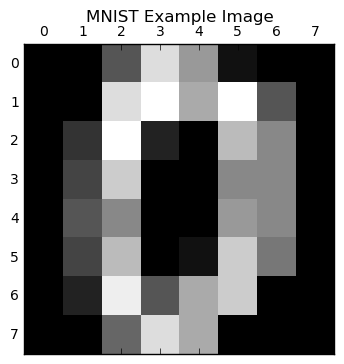

In [2]:
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

plt.matshow(digits.images[0],cmap='gray') 

plt.title('MNIST Example Image')

We now split our dataset into a train and test set. We will use 80% of the data for training and 20% for testing. In practice you should also use a validation set but for the purpose of this tutorial a train and test is sufficient.

In [3]:
num_examples, data_dim = X_digits.shape
num_train_examples = int(0.8*num_examples)
num_test_exmaples = num_examples - num_train_examples

#shuffle our data
X,y = shuffle(X_digits,y_digits)

#one-hot encode our labels
y_enc = np.zeros((num_examples,10))
y_enc[np.arange(num_examples), y] = 1

#split our data
X_train = X[0:num_train_examples,:]
y_train = y_enc[0:num_train_examples,:]

X_test = X[num_train_examples:,:]
y_test = y_enc[num_train_examples:,:]

print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(1437, 64) (1437, 10)
(360, 64) (360, 10)


## Building a Neural Network

### The Architecture
We will start with the simplest neural network of 3 layers; input, hidden, and output. Our input size will be the dimension of our data (64) which is the number of pixels in our image, our output size will be 10 since there are 10 possible digits, and our hidden size will be left up to us. We can see a general picture of this below

![Simple Neural Network Architecture](img/nn.jpeg)

### The Activation Function
Once we have the architecture of our network decided on we need a few more pieces before we can train it. One of the most crucial pieces is the activation function which adds a non-linearity to our network. We will see later that without this non-linearity the entire network can be compressed into a single matrix multiplication. The most common activation function in the current literature is [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) but historically it has been [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function). For this tutorial I will stick with sigmoid due to its historical importance and ease of understanding the math of backpropogation.

$$ReLU(x) = max(0,x)$$
![ReLU Activation Function](img/relu.svg)

$$sigmoid(x) = \frac{1}{1 + e^{-x}}$$
![Sigmoid Activation Function](img/sigmoid.png)

### The Output
Depending on your task you might also need to change the activation function of the output layer as well. In our case since we are performing a classification task we want each node to represent a probability of being that digit. The [softmax](https://en.wikipedia.org/wiki/Softmax_function) activation function does exactly this. Softmax  ensures that the output layer follows the rules of being a probability distribution. The exact formular for this is shown below.

$$softmax(x_i) = \frac{e^{x_i}}{\sum_{k=1}^K e^{x_k}}$$

Below we define our activation function and our output activation function.

In [4]:
def sigmoid(x,deriv=False):
    '''
    x: vector input to activation function
    deriv: indicator for whether we are calculating 
           the derivative of sigmoid
           
    The deriv parameter will be helpful in the backpropogation 
    calculations.
    '''
    if(deriv==True):
        return x*(1-x)
    return 1.0 / (1.0 + np.exp(-x))

In [5]:
def softmax(x):
    '''
    x: vector input from the last layer of our network
    
    Here I use a mathematical trick to ensure the calculations
    are easier to compute. You can test yourself by ensuring that
    this code correctly implements the formula above.
    '''
    e = np.exp(x - np.max(x,axis=1,keepdims=True))
    return e / (np.sum(e,axis=1,keepdims=True))

## Learning
Now that we have defined our network we can begin to look at how exactly this structure can be used for classification and how to train such a model. We will start with the easy work first which is the classification or "feed-forward" step.

### Forward Propogation
Let $x$ be our input vector and $\hat{y}$ be our output vector. For the forward propogation step we are simply concatenating a series of linear classifiers with a non-linearity. If you are familiar with [logistic regression] you can consider each layer performing a logistic regression followed by a non-linearity. Below is the exact definition of forward propogation

$$\begin{align}
  z_1 &= xW_1 + b_1  \\
  a_1 &= \sigma (z_1) \\
  z_2 &= a_1W_2 + b_2 \\
  \hat{y}a_2 &= softmax(z_2)
\end{align}
$$

Here $W_1$ is a matrix of weights representing the weighted connections between the input and hidden layer, $b_1$ is a bias term, $W_2$ is the matrix of weights connecting the hidden and output layer, and $b_2$ is the bias term for the last layer.

Note that these formulas will vary depending on your non-linearity and number of layers but the mathematics behind it does not change. We can also see from these formulas why a non-linearity is important as without it we could simply compact all the computation into a single matrix multiplication which would result in simple logistic regression.

### Backpropogation
Now we get to the real meat of this tutorial which is backpropogation. The goal of backpropogation is to minimize the error in our training data. A common error function to use is [cross-entropy]() which we define below.

$$L(y,\hat{y}) = -\frac{1}{N}\sum_{n\in N}\sum_{i\in C} y_{n,i}log(\hat{y}_{n,i})$$

Now we have everything we need to start our derivation of backpropogation. The key trick to backpropogation is knowing that we will be optimizing this network with gradient descent. Knowing this all we need to be able to compute is the gradient of the loss with respect to all of the parameters of the network. With this we can make a "step" in the right direction during the optimization process. 

The reason this algorithm is called backpropogation is the direction in which we go through the network when calculating the gradients is in reverse to the direction we took during forward propogation. Knowing this we first calculate the derivative of the error with respect to the output of the last layer. The derivation for this particular step is rather cumbersome but leads to a elegant solution

$$\delta_3 = \frac{\partial L}{\partial z_2} = y-\hat{y}$$

Let us also define

$$\delta_2 = \frac{\partial L}{\partial z_1}$$

which translates to the derivative of the loss with respect to the output of layer 1 before applying the activation function or "pre-activation" for short. To calculate this derivative we apply the chain rule of calculus

$$\begin{align}
\delta_2 &= \frac{\partial L}{\partial z_1} \\
&= \frac{\partial L}{\partial z_2}\frac{\partial z_2}{\partial z_1} \\
&= \delta_3 \frac{\partial z_2}{\partial a_1}\frac{\partial a_1}{\partial z_1} \\
&= \delta_3 W_2 (\sigma(z_1)(1-\sigma(z_1)))
\end{align}
$$

With that all of the hard math is done believe it or not. We can easily define all of the gradients we need now

$$
\begin{align}
\delta_3 &= y-\hat{y} \\
\frac{\partial L}{\partial W_2} &= \frac{\partial L}{\partial z_2}\frac{\partial z_2}{\partial W2} = a_1^T\delta_3 \\
\frac{\partial L}{\partial b_2} &= \delta_3 \\
\delta_2 &= \delta_3 W_2 (\sigma(z_1)(1-\sigma(z_1))) \\
\frac{\partial L}{\partial W_1} &= \frac{\partial L}{\partial z_1}\frac{\partial z_1}{\partial W_1} = x^T\delta_2 \\
\frac{\partial L}{\partial b_1} &= \delta_2
\end{align}
$$

And that's it! With this we can now apply gradient descent to train our network. And not one mention of neurons or any relation to the brain at all :). I believe that it is easier to not think of individual neurons and look at these networks as a series of matrix multiplies and non-linearities. This way it is easier to see the relation to other algorithms such as logistic regression and allows you to look at papers which do delve into math and not be afraid. If you feel this was a bit too rushed and you would like more details than check out some of the suggested material I would reccomend at the end of this tutorial. On to the code!

## The Code

In [6]:
class NeuralNetwork(object):
    
    def __init__(self,nb_units,learning_rate,random_seed=1234):
        '''
        nb_units: The number of units in our hidden layer
        learning_rate: Learning rate for gradient descent
        random_seed: Seed for our random number generator
        
        It is always good to seed your random number generator in 
        your code as neural networks are inherently random and 
        doing this allows easier reproducibility of your results.
        '''
        self.W1 = np.random.randn(64, nb_units) / np.sqrt(64)
        self.b1 = np.zeros([1,nb_units])
        self.W2 = np.random.randn(nb_units, 10) / np.sqrt(nb_units)
        self.b2 = np.zeros([1,10])
        
        self.lr = learning_rate
        
    def loss(self,X,y):
        '''
        X: Matrix of data points
        y: Matrix of labels in one-hot encoded form
        
        This function computes our cross-entropy loss. Notice that it
        is very expensive to compute this as we have to iterate over
        all examples while in backpropogation we only need its derivative
        which is much easier to compute
        '''
        z1 = X.dot(self.W1) + self.b1
        a1 = sigmoid(z1)
        z2 = a1.dot(self.W2) + self.b2
        probs = softmax(z2)
        
        log_probs = np.log(probs*y)
        log_probs[log_probs == -np.inf] = 0
        
        loss = -np.sum(log_probs)
        return (1./len(X)) * loss
    
    def accuracy(self,X,y):
        '''
        X: Matrix of data points
        y: Matrix of labels in one-hot encoded form
        
        A helper function to compute the accuracy of our network
        '''
        correct = 0
        incorrect = 0
        for i in xrange(len(y)):
            x = X[i,:]
            label = np.nonzero(y[i])[0][0]
            pred = model.predict(x)
            if label == pred:
                correct += 1
            else:
                incorrect += 1
        return float(correct) / (correct + incorrect)
    
    def predict(self,x):
        '''
        x: A vector of pixels for a single example
        
        Runs our network for a single example to get a prediction
        '''
        z1 = x.dot(self.W1) + self.b1
        a1 = sigmoid(z1)
        z2 = a1.dot(self.W2) + self.b2
        probs = softmax(z2)
        return np.argmax(probs, axis=1)
        
    def train(self,X,y,nb_epoch):
        '''
        X: Matrix of data points
        y: Matrix of labels in one-hot encoded form
        nb_epoch: The number of epochs to train for
        
        This function performs the forward propogation and backward 
        propogation for the given number of epochs
        '''
        n_training,data_dim = X.shape
        for i in xrange(nb_epoch):
            for j in xrange(n_training):
                x = X[j,:].reshape([1,data_dim])
                
                #Forward propogation
                z1 = x.dot(self.W1) + self.b1
                a1 = sigmoid(z1)
                z2 = a1.dot(self.W2) + self.b2
                probs = softmax(z2)
                
                #Backpropogation
                d3 = -(y[j]-probs)
                
                dW2 = a1.T.dot(d3)
                db2 = np.sum(d3,axis=0,keepdims=True)
                
                d2 = d3.dot(self.W2.T) * sigmoid(a1,deriv=True)
                
                dW1 = x.T.dot(d2)
                db1 = np.sum(d2,axis=0)
                
                #Update weights
                self.W1 += -lr * dW1
                self.b1 += -lr * db1
                self.W2 += -lr * dW2
                self.b2 += -lr * db2
                
            #print our loss at the end of each epoch
            print "Loss at epoch {}: {}".format(i,self.loss(X,y))
            
        print "Training complete!"

In [7]:
nb_epoch = 10
nb_units = 200
lr = 0.01

#define our model
model = NeuralNetwork(nb_units,lr)

#train our model
model.train(X_train,y_train,nb_epoch)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log


Loss at epoch 0: 0.227393185523
Loss at epoch 1: 0.124926830203
Loss at epoch 2: 0.0849156272638
Loss at epoch 3: 0.0621657498182
Loss at epoch 4: 0.047015334521
Loss at epoch 5: 0.0361425551262
Loss at epoch 6: 0.0284811106629
Loss at epoch 7: 0.0234222873346
Loss at epoch 8: 0.0199735525547
Loss at epoch 9: 0.0174566992262
Training complete!


In [8]:
#test our model
print model.accuracy(X_test,y_test)

0.977777777778


## Things to Try
Below are some exercises you can attempt to confirm you understand the backpropogation algorithm and the different components of a neural network. I also list some "essential reading" which goes over some of these methods. I highly reccomend you go over those papers as they will be your bread and butter of sorts.

- Play around with the various hyperparameters
- Add dropout
- Add momentum
- Add nesterov momentum
- Add l2 regularization
- Try better activation functions such as tanh or ReLU
- Add support for any number of layers

## Important Reads
- [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)
- [On the importance of initialization and momentum in deep learning](http://jmlr.org/proceedings/papers/v28/sutskever13.pdf)
- [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852)